# CIS 678: Project 1: Recommender Systems

By: Haley Siwek & Kyle Kane

### Introduction

For this project, the algorithm serves as a recommender system that recommends the top five 0 values (bird species not reported as being seen by bird watchers) that are likely nonzero (bird species seen by bird watchers) based on KNN calculations. The data was zero inflated and skewed left. When thinking about bird counts this makes sense because you are more likely to not see a particular bird species or 1 or 2, rather than 85 for instance.

### Approach

A histogram visually presented the initial spread of the data and that it was not normal. The goal of this algorithm is to process the data in a normalized fashion, identify the best distance metric and weighting to find the k-nearest neighbors, and provide the top five as a recommendation. The histogram confirmed the data distribution is zero-inflated negative binomial, which meant that a normalization process was needed. Since KNN uses distance in its calculation, what distance metric used also needed to be considered. Finally, adding a weight to the distance metric may be necessary if the data has large values or if it is highly clustered. Hyper parameter tuning will be evaluated by calculating the mean absolute error (MAE).

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

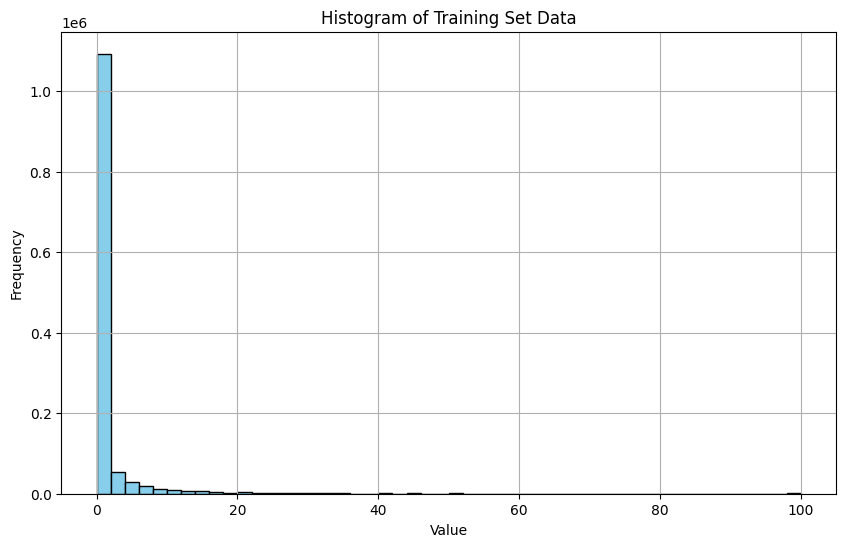

In [ ]:
# Load in provided training and testing data
train_df = pd.read_csv('training_set.csv', index_col=0)
test_df = pd.read_csv('test_set.csv', index_col=0)

# Histogram of the training set data to get a look at the distribution
plt.figure(figsize=(10, 6))
plt.hist(train_df.values.flatten(), bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Training Set Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

### Normalization

When looking at different normalization techniques to use, we tried a few to see what ones were most effective. We initially tried min-max normalization. This was largely ineffective. Our assumption for why this is would be because of how skewed the data was. If you have heavily skewed data or outliers, the min-max normalization does not really impact the skewness of the data. So from there, we shifted to log normalization, which was much more successful, and while the data was still skewed with how many 0 values existed in the dataset, skewness was going to be persistent, so it was about reducing or compressing the larger values so the model could be more accurate. The reason we went with the equation we used was because we could adjust the beta value in order to dictate how compressed the large values would be. It offered another way for us to hypertune our model with scaling.

In [ ]:
# Scaled Logarithmic Normalization
def custom_normalization(df, beta):
  for column in df.columns:
    column_sum = df[column].sum() # calculating the sum of each column so that the data is scaled between 0 and 1
    df[column] = np.log((df[column] / column_sum) * beta + 1) #log of the proportion a column value has to the sum beta allows us to adjust how much large value compression occurs
  return df

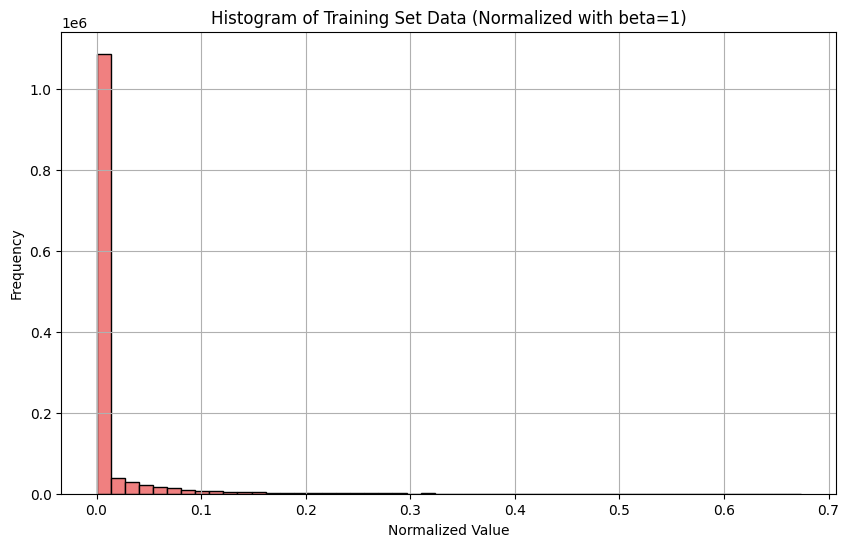

In [ ]:
beta = 1
train_df_normalized = custom_normalization(train_df.copy(), beta)

# Histogram of the normalized training set data
plt.figure(figsize=(10, 6))
plt.hist(train_df_normalized.values.flatten(), bins=50, color='lightcoral', edgecolor='black')
plt.title(f'Histogram of Training Set Data (Normalized with beta={beta})')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Distance Metrics

Custom functions were written for the Euclidean, cosine, and Manhattan distance metrics. Evaluaiton fo the effectiveness of these metrics can be found in the results and cross validation section.

In [ ]:
# Euclidean Distance
def euclidean_distance_matrix(train_data, test_row):
    test_row = test_row.values.reshape(1, -1) # 2D reshape
    train_data_matrix = train_data.values.T # Transposing the data
    # Compute sum of squared differences (SSD)
    squared_diff = (train_data_matrix - test_row) ** 2
    squared_sum = np.sum(squared_diff, axis=1)
    return np.sqrt(squared_sum) #compute final euclidean distance

In [ ]:
# Cosine Distance
def cosine_distance(vec1, vec2):
  vec1 = np.array(vec1) #computing the two vectors
  vec2 = np.array(vec2)
  dot_product = np.dot(vec1, vec2)
  # Compute the magnitudes/length (Euclidean norms) of the vectors
  norm_vec1 = np.linalg.norm(vec1)
  norm_vec2 = np.linalg.norm(vec2)
  cosine_similarity = dot_product / (norm_vec1 * norm_vec2)
  # Cosine distance is 1 minus cosine similarity
  cosine_distance = 1 - cosine_similarity
  return cosine_distance

In [ ]:
# Manhattan Distance
def manhattan_distance_matrix(train_data, test_row):
    test_row = test_row.values.reshape(1, -1)  # 2D reshape
    train_data_matrix = train_data.values.T  # Transpose the data to align with columns
    # Compute and sum absolute differences
    abs_diff = np.abs(train_data_matrix - test_row)
    distance_sum = np.sum(abs_diff, axis=1)
    return distance_sum

### Weighting

No weighting, Gaussian weighting, and inverse distance weighting were tested and evaluated. Gaussian weighting gives more weight to points within shorter distances and less weight to points further away from centroids. Inverse distance weighting also gives more weight to points closer to the centroids and less to points further away, but the influence of the weight is customizable through hyperparameter tuning the power value. Through experimentation and comparing for lower MAE values, inverse distance weighting was found to be the optimal weighting metric for this algorithm's data.

In [ ]:
# Gaussian Weighting
def gaussian_weight(distances, sigma=1.0): #sigma controls how quickly weights decrease
    distances = np.array(distances)
    return np.exp(-distances**2 / (2 * sigma**2))

# Inverse Distance Weighting
def inverse_distance_weighting(distances, power=2, epsilon=1e-9): #alpha/power controls weight decay
    distances = np.array(distances) + epsilon # Add epsilon to avoid division by zero
    weights = 1 / (distances ** power)
    weights /= np.sum(weights) # Normalize weights so they sum to 1
    return weights

### KNN

The KNN algorithm calculates the distances between a given test row and all the rows in a training dataset and then identifies the k closest neighbors based on a selected distance metric. This function accepts various distance metrics for flexibility and accessibility in hyperparamter tuning.

In [ ]:
# K-Nearest Neighbors (KNN)
def get_k_nearest_neighbors(dist, train_data, test_row, k):
    # Calculate the distances between the test row and all rows in the training data
    if dist == 1:#the series of if statements allows us to run various distance metrics for comparison
      distances = euclidean_distance_matrix(train_data, test_row)
    if dist == 2:
      distances = np.array([cosine_distance(train_data.loc[:, col], test_row) for col in train_data.columns])
    if dist == 3:
      distances = manhattan_distance_matrix(train_data, test_row)
    weights = inverse_distance_weighting(distances)
    # Get the indices of the k smallest distances
    nearest_neighbors = np.argsort(distances)[:k]
    # Return indicies of KNN
    return nearest_neighbors, weights[nearest_neighbors]

### Recommendation

The recommendation provides bird species for a given test row based on the KNN results. It utilizes the KNN algorithm to identify the species most likely to be relevant to the test row based on the species present in its neighbors and their weights.

In [ ]:
# Bird species recommendation based on KNN results
def recommend_species(dist, train_data, test_row, k):
    neighbors, weights = get_k_nearest_neighbors(dist, train_data, test_row, k)
    species_scores = {}  # Store frequency score for each species
    for species in test_row.index:
        # If the species is missing in the test row (value == 0), check if it's recommended
        if test_row[species] == 0:
            species_count = 0 # Count how many of the neighbors have this species
            for i, neighbor_idx in enumerate(neighbors):
                  if train_data.loc[species, train_data.columns[neighbor_idx]] > 0:  # Species is present in neighbor's checklist
                    species_count += weights[i]
            if species_count > 0:
                species_scores[species] = species_count
    # Sort species by frequency of occurrence in neighbors and select top 5
    sorted_recommendations = sorted(species_scores.items(), key=lambda x: x[1], reverse=True)
    # Extract just the species names for the top 5
    recommendations = [species for species, _ in sorted_recommendations[:5]]
    return recommendations

### Results & Cross Validation

To perform cross validation, the training data was split into two groups, 80% to train and 20% to test against. Five random non-zero values are set to zero in each column of the test data grouping. For each row in the test data grouping, the model makes recommendations for missed bird sightings. The actual and predicted values (train vs. tested) are compared and used to calculate the mean absolute error (MAE).

(Euclid) MAE values with corresponding k:
k=5, MAE=0.06241275815780906
k=10, MAE=0.05990643660834935
k=15, MAE=0.05912153875656125
k=20, MAE=0.05912153875656125
k=25, MAE=0.05856854254280146
k=28, MAE=0.05843475313624667
k=29, MAE=0.058470430311327946
k=30, MAE=0.05850610748640923
k=35, MAE=0.05834556019854348
k=40, MAE=0.05847934960509827
k=45, MAE=0.05846151101755763
k=50, MAE=0.05843475313624667


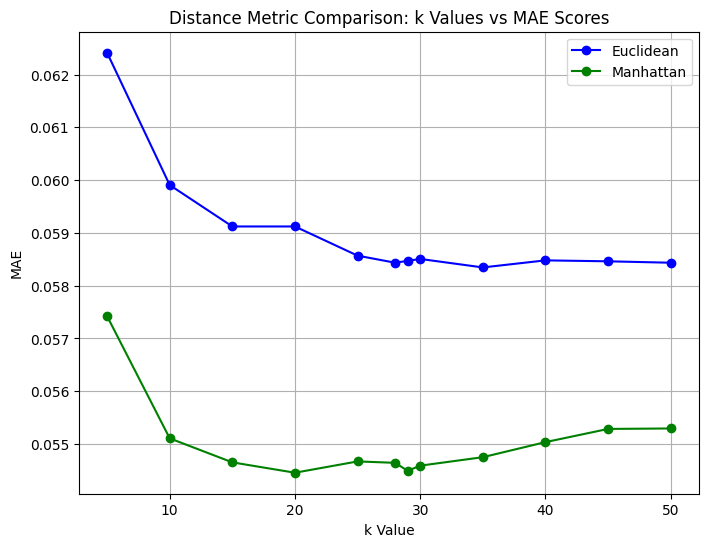

In [ ]:
# Cross Validation: Mean Absolute Error (MAE)
# Split train_df into trainMAE (80%) and testMAE (20%)
trainMAE, testMAE = train_test_split(train_df.T, test_size=0.2, random_state=42)
trainMAE = trainMAE.T
testMAE = testMAE.T
# Modify testMAE to set 5 random nonzero values in each column to zero
testMAE_modified = testMAE.copy()
for col in testMAE.columns:
    non_zero_indices = testMAE[col].to_numpy().nonzero()[0]
    if len(non_zero_indices) >= 5:  # Check there are at least 5 nonzero values
        indices_to_remove = np.random.choice(non_zero_indices, 5, replace=False)
        testMAE_modified.iloc[indices_to_remove, testMAE.columns.get_loc(col)] = 0

# Calculate MAE
def evaluate_recommendations(dist, train_data, test_data, original_test_data, k):
    actual_values = []
    predicted_values = []
    for checklist_id, test_row in test_data.items():
        # Get recommended species
        recommended_species = recommend_species(dist, train_data, test_row, k)
        for species in test_row.index:
            # Only evaluate species that were modified (set to zero)
            if test_data.loc[species, checklist_id] == 0:
                # Actual: From original data
                actual = 1 if original_test_data.loc[species, checklist_id] > 0 else 0
                actual_values.append(actual)
                # Predicted: From recommendations
                predicted = 1 if species in recommended_species else 0
                predicted_values.append(predicted)
    # Calculate and return MAE
    return mean_absolute_error(actual_values, predicted_values)

# Evaluate recommendations for a range of k values and find the lowest MAE
def evaluate_k_range(dist, train_data, test_data, original_test_data, k_range):
    mae_results = {}
    for k in k_range:
        # Calculate MAE for the current k
        mae = evaluate_recommendations(dist, train_data, test_data, original_test_data, k)
        mae_results[k] = mae
    return mae_results

k_range = [5,10,15,20,25,28,29,30,35,40,45,50]  # Evaluate k values
# Compare distance metrics
mae_results_Euclid = evaluate_k_range(1, trainMAE, testMAE_modified, testMAE, k_range)
mae_results_Man = evaluate_k_range(3, trainMAE, testMAE_modified, testMAE, k_range)
best_k = min(mae_results_Euclid, key=mae_results_Euclid.get)
# Print the 5 MAE values with corresponding k
print("(Euclid) MAE values with corresponding k:")
for k, mae in mae_results_Euclid.items():
    print(f"k={k}, MAE={mae}")
# Plot k values vs MAE scores for Euclidean and Manhattan
plt.figure(figsize=(8, 6))
plt.plot(list(mae_results_Euclid.keys()), list(mae_results_Euclid.values()), marker='o', linestyle='-', color='b', label='Euclidean')
plt.plot(list(mae_results_Man.keys()), list(mae_results_Man.values()), marker='o', linestyle='-', color='g', label='Manhattan')
plt.title('Distance Metric Comparison: k Values vs MAE Scores')
plt.xlabel('k Value')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.show()

### Distance Metric Comparison & Evaluation

The Euclidean and Manhattan distance metrics were used to produce recommendations, and their corresponding MAE results were plotted for comparison. One of the reasons cosine was not selected as the optimal distance metric was because use of the cosine distance metric significantly increased time for execution. This did not allow for easy or realistic experimentation and optimization. As viewed on the plot, the MAE curve minimum was higher with the implemented Euclidean distance metric than the Manhattan. This led to the Manhattan distance metric being selected for generation of our submission file. Since Manhattan proved to be more effective and the Minkowski distance metric is a combination of the Euclidean and Manhattan distance metrics, the Minkowski distance metric was not considered a valuable option and was not tested.

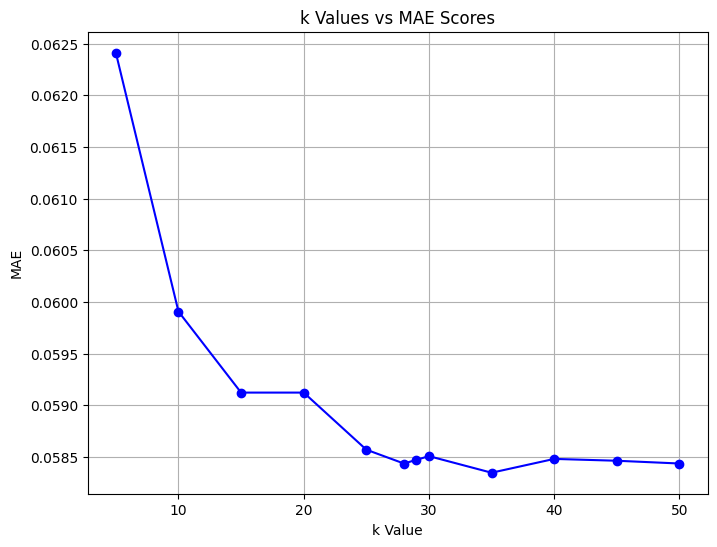

In [ ]:
# Euclidean distance metric selected -> Plot results to find optimal k
k_values = list(mae_results_Euclid.keys())  # k values from the mae_results
mae_scores = list(mae_results_Euclid.values())  # Corresponding MAE values
plt.figure(figsize=(8, 6))
plt.plot(k_values, mae_scores, marker='o', linestyle='-', color='b')
plt.title('k Values vs MAE Scores')
plt.xlabel('k Value')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

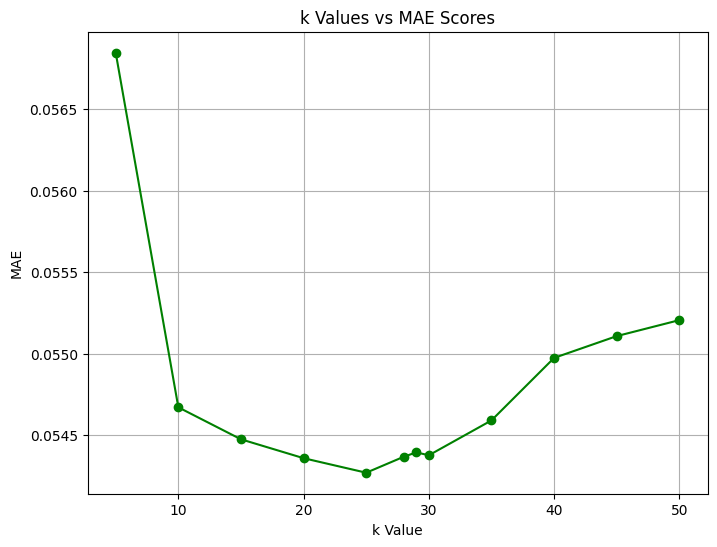

In [ ]:
# Manhattan distance metric selected -> Plot results to find optimal k
k_values = list(mae_results_Man.keys())  # k values from the mae_results
mae_scores = list(mae_results_Man.values())  # Corresponding MAE values
plt.figure(figsize=(8, 6))
plt.plot(k_values, mae_scores, marker='o', linestyle='-', color='g')
plt.title('k Values vs MAE Scores')
plt.xlabel('k Value')
plt.ylabel('MAE')
plt.grid(True)
plt.show()

### Cross Validation Results

The cross validation results are visuslly represented in the plot of k values versus MAE scores. Through experimentation, a suitable range of k values was plotted. The resulting curve is concave up, and the minimum value on the curve represents the optimal k value. As seen on the above plot, k=25 was found to be the minimum value on the curve and was chosen to be used in generation of the submission file.

### Submission

In [ ]:
# Load the sample_submission.csv
sample_submission_df = pd.read_csv('sample_submission.csv')
results = []
for checklist_id, test_row in test_df.items():
    # For each test checklist, get the recommended species
    recommended_species = recommend_species(3, train_df, test_row, 25)
    for species in test_row.index:
        # If the species is missing in the checklist (value == 0), check if it's in the recommendation list
        if test_row[species] == 0:
            recommendation = 1 if species in recommended_species else 0
        else:
            recommendation = 0  # If the species is present in the checklist (non-zero value), set it as 0
        # Add the row to the results (Id, species, and Expected recommendation)
        results.append({'Id': checklist_id, 'Expected': recommendation})
submission_df = pd.DataFrame(results)
submission_final = pd.DataFrame(columns=["Id", "Expected"])
submission_final["Id"] = sample_submission_df["Id"]
submission_final["Expected"] = submission_df["Expected"]
submission_final.to_csv('submission_attempt.csv', index=False)
print("Sample submission CSV created successfully!")

Sample submission CSV created successfully!


### Conclusion

The algorithm uses logarithmic normalization, the Manhattan distance metric, Inverse distance weighting, KNN with k=25, and 80%/20% data split cross validation with MAE calculations to provide a suitable recommendation. A strength of the algorithm is its accuracy in tuning to the optimal k using the implemented cross validation techniques. Interestingly, euclidean distance scored better with the gaussian weighting metric but when we switched to inverse distance metric for weighting manhattan performed better. If we were to recomplete this project from the beginning, there are a few changes we would have made to the overall process. First is to do the data processing step first. By doing it later, our early findings such as the correct number of neighbors were inaccurate, since we had not analyzed the distribution of data or normalized it initially. Additionally, with the computational cost of hypertuning k, a future improvement for this algorithm would be to precompute distance matrices rather than recomputing it every time.